In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gc
import nltk
from difflib import *
import gensim.models.keyedvectors as word2vec
from keras import metrics
from keras.models import Model
from keras.layers import *
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First we read in the spam file and remove non informative columns consists of NaN.

In [3]:
sms = pd.read_csv('spam.csv',encoding='latin-1')
sms = sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms = sms.rename(columns={"v1":"class", "v2":"text"})
sms.head(10)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


We can see that the data contains two columns, the email text and class label of ham/spam. Next, we will do some basic EDA of the spam data.

In [4]:
sms.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

Text(0.5,1,'Number of ham and spam messages')

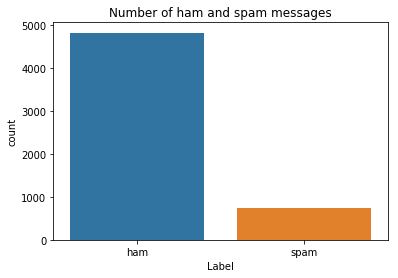

In [5]:
sns.countplot(sms['class'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8F145A978>]],
      dtype=object)

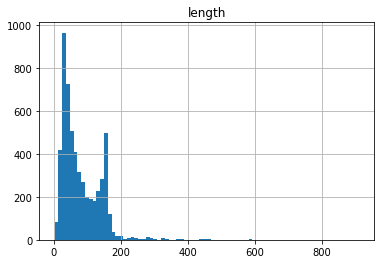

In [4]:
sms['length'] = sms['text'].apply(len)
sms.hist(column='length', bins=80)

We can see from the EDA above that the proportion of an email being ham is about 13%, and that most of the emails has length below 180 words.

In [6]:
X = sms['text']
Y = sms['class']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split 80% of data into train and 20% of data into test set.

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

Before fitting model, we have to preprocess the data, such as tokenizing the data and converting the text to sequences.
Padding are added to ensure that all the sequences have the same shape. We take max_len to be an arbitrary length of 150 is chosen, sentence that is shorter than 180 words are padded.

In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen = max_len)
print('sequence encoding of first text message')
print(sequences[0])
print('\n')
print('padded sequence of first text message')
print(sequences_matrix[0])
print('\n')
print('shape of padded sequence')
print(sequences_matrix.shape)

sequence encoding of first text message
[37, 635, 808, 8, 12, 19]


padded sequence of first text message
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  37 635 808   8  12  19]


shape of padded sequence
(4457, 150)


Now we can define the architecture of our basic model, using the tokenized sequence as input.

In [9]:
def mod():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    lstm_out = LSTM(64)(layer)
    layer = Dense(256,name='FC1', activation = 'relu')(lstm_out)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer', activation = 'sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [10]:
model = mod()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 159,137
Trainable params: 159,137
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0005)])

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 7s 2ms/step - loss: 0.2884 - acc: 0.8973 - val_loss: 0.1028 - val_acc: 0.9821
Epoch 2/10
3565/3565 [==============================] - 7s 2ms/step - loss: 0.0654 - acc: 0.9826 - val_loss: 0.0535 - val_acc: 0.9843
Epoch 3/10
3565/3565 [==============================] - 7s 2ms/step - loss: 0.0400 - acc: 0.9865 - val_loss: 0.0500 - val_acc: 0.9843
Epoch 4/10
3565/3565 [==============================] - 7s 2ms/step - loss: 0.0297 - acc: 0.9910 - val_loss: 0.0381 - val_acc: 0.9877
Epoch 5/10
3565/3565 [==============================] - 7s 2ms/step - loss: 0.0209 - acc: 0.9950 - val_loss: 0.0406 - val_acc: 0.9854


The accuracy is about 99%, we will then process our test set and evaluate its classification accuracy.

In [12]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1115/1115 [==============================] - 1s 779us/step
Test set
  Loss: 0.048
  Accuracy: 0.984


Test accuracy is about 98.4%, which is acceptable. Next we build model using pretrained word vector from google news

In [35]:
# Load Google's pre-trained Word2Vec model.
word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)  

embed_size = 300
embeddings_index = dict()
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
print('Loaded %s word vectors.' % len(embeddings_index))            
gc.collect()

num_words = 1000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tok.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Embedded matrix shape :', embedding_matrix.shape)
gc.collect()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Loaded 3000000 word vectors.
Embedded matrix shape : (1000, 300)


0

In [36]:
words = []
for i in range(0,154):
        for j in range(0,12):
            if type(ehr_character.iloc[i,j]) == str:
                words = words + ehr_character.iloc[i,j].split()
print('There are {} words for 12 variables and 154 rows'.format(len(words)))
print('The proportion of words that are in google news dictionary is {:.3}%'.format(np.mean([1 if x in embeddings_index else 0 for x in words])*100))

There are 84739 words for 12 variables and 154 rows
The proportion of words that are in google news dictionary is 88.2%


In [100]:
def mod2():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words, 300, weights=[embedding_matrix], input_length=150, trainable=False)(inputs)
    lstm_out = LSTM(64)(layer)
    layer = Dense(256,name='FC1', activation = 'relu')(lstm_out)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer', activation = 'sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

The embedding layer is replaced by pre-trained weights that is set to be non-trainable in our model.

In [101]:
model2 = mod2()
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 180)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 410,337
Trainable params: 110,337
Non-trainable params: 300,000
________________________________________________________________

In [80]:
model2.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0005)])
accr2 = model2.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr2[0],accr2[1]))

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0358 - acc: 0.9874 - val_loss: 0.0532 - val_acc: 0.9843
Epoch 2/10
1115/1115 [==============================] - 2s 2ms/step
Test set
  Loss: 0.080
  Accuracy: 0.981


Even though validation accuracy is a little less than model1, the test accuracy is about the same. However, it is clear that using pre-trained word vectors in this case does not boost our model, one reason might be that there are many common words in email that do not appear on vocab list of google news.

Next we try lstm model with attention layer, as defined by HATT model proposed in paper 'Hierarchical Attention Networks for Document Classification' and implemented in https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py by Richard Liao

In [29]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [30]:
def mod4():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    l_gru = Bidirectional(GRU(64, return_sequences=True))(layer)
    att = AttLayer(50)(l_gru)
    layer = Dropout(0.2)(att)
    layer = Dense(1,name='out_layer', activation = 'sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [31]:
model4 = mod4()
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 100)          100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 128)          63360     
_________________________________________________________________
att_layer_2 (AttLayer)       (None, 128)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129       
Total params: 169,989
Trainable params: 169,989
Non-trainable params: 0
_________________________________________________________________


In [32]:
model4.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping
                                          (monitor='val_loss',min_delta=0.0005)])
accr4 = model4.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr4[0],accr4[1]))

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 19s 5ms/step - loss: 0.3571 - acc: 0.8600 - val_loss: 0.1164 - val_acc: 0.9596
Epoch 2/10
3565/3565 [==============================] - 16s 5ms/step - loss: 0.0683 - acc: 0.9820 - val_loss: 0.0604 - val_acc: 0.9865
Epoch 3/10
3565/3565 [==============================] - 16s 5ms/step - loss: 0.0470 - acc: 0.9877 - val_loss: 0.0517 - val_acc: 0.9877
Epoch 4/10
1115/1115 [==============================] - 2s 2ms/step
Test set
  Loss: 0.046
  Accuracy: 0.984


The accuracy is about the same, probably because the sample size is too small for this complicated model. However, one advantage of using attention layer is that we can know from the attention weight which key words contributes more to the prediction of target variable. We will calculate the attention weights and pick one sample to visualize the attention weight of each word in the message.

In [12]:
get_layer_output = K.function([model4.layers[0].input, K.learning_phase()], [model4.layers[2].output])
out = get_layer_output([sequences_matrix, 0])[0]
print(out.shape)

(4457, 150, 128)


In [20]:
index = 96
t = model4.layers[3].get_weights()
eij = np.tanh(np.dot(out[index], t[0]) + t[1])
ai = np.dot(eij,t[2])
ai = np.exp(ai)
ai = np.squeeze(ai)
weights = ai/np.sum(ai)

In [21]:
K = 3
topKeys = np.argpartition(weights,-K)[-K:]
keys = sequences_matrix[index][topKeys]

The text message of index 96 is: 
 1st wk FREE! Gr8 tones str8 2 u each wk. Txt NOKIA ON to 8007 for Classic Nokia tones or HIT ON to 8007 for Polys. Nokia/150p Poly/200p 16+


The words that has the 3 largest attention weights are:
nokia
txt
tones


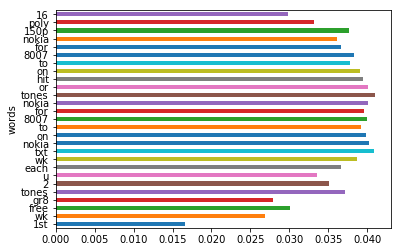

In [22]:
word_dict = tok.word_index
print('The text message of index {} is: \n'.format(index),X_train.iloc[index])
print('\n')
print('The words that has the 3 largest attention weights are:')
for k in keys:
    print(list(word_dict.keys())[list(word_dict.values()).index(k)])
    
word_idx = sequences_matrix[index][sequences_matrix[index] != 0]
words = [list(word_dict.keys())[list(word_dict.values()).index(k)] for k in word_idx]
words_weight = weights[sequences_matrix[index] != 0]
df = pd.DataFrame({'words': words, 'weight': words_weight})
ax = df.plot.barh(x='words', y='weight', rot=0, legend = False)